In [1]:
%cd ..

/home/work/AnacondaProjects/cs7150_project_chyvae


In [2]:
import collections
import torch
import numpy as np
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from parse_config import ConfigParser
from trainer import Trainer

In [3]:
%matplotlib inline

In [4]:
# torch.autograd.set_detect_anomaly(True)

In [5]:
# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [6]:
Args = collections.namedtuple('Args', 'config resume device')
config = ConfigParser.from_args(Args(config='config.json', resume=None, device=None))

In [7]:
logger = config.get_logger('train')

In [8]:
# setup data_loader instances
data_loader = config.init_obj('data_loader', module_data)
valid_data_loader = data_loader.split_validation()

Keys in the dataset: KeysView(<numpy.lib.npyio.NpzFile object at 0x7f45842dfd60>)
Dataset loaded : OK.


In [9]:
# build model architecture, then print to console
model = config.init_obj('arch', module_arch)

In [10]:
criterion = getattr(module_loss, config['loss'])

In [11]:
metrics = [getattr(module_metric, metric) for metric in config['metrics']]

In [12]:
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = config.init_obj('optimizer', torch.optim, trainable_params)

lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)

In [13]:
trainer = Trainer(model, criterion, metrics, optimizer, config=config,
                  data_loader=data_loader,
                  valid_data_loader=valid_data_loader,
                  lr_scheduler=lr_scheduler)

In [14]:
trainer._resume_checkpoint('saved/models/Shapes_ChyVAE/0802_175221/checkpoint-epoch100.pth')

Loading checkpoint: saved/models/Shapes_ChyVAE/0802_175221/checkpoint-epoch100.pth ...
Checkpoint loaded. Resume training from epoch 101


In [15]:
metrics = trainer.validate(20)

    epoch          : 0
    loss           : -11122.962456597223
    log_likelihood : -11330.8779296875
    reconstruction_error: 10.866299629211426
    disentanglement_metric: 0.19854164123535156
    epoch          : 1
    loss           : -11122.96275499132
    log_likelihood : -11330.8779296875
    reconstruction_error: 10.866297721862793
    disentanglement_metric: 0.20329861342906952
    epoch          : 2
    loss           : -11122.962646484375
    log_likelihood : -11330.8779296875
    reconstruction_error: 10.86629867553711
    disentanglement_metric: 0.20232640206813812
    epoch          : 3
    loss           : -11122.962836371527
    log_likelihood : -11330.87890625
    reconstruction_error: 10.866299629211426
    disentanglement_metric: 0.19788196682929993
    epoch          : 4
    loss           : -11122.962917751736
    log_likelihood : -11330.876953125
    reconstruction_error: 10.866297721862793
    disentanglement_metric: 0.20222222805023193
    epoch          : 5
  

In [16]:
reconstruction_errors = np.array([m['reconstruction_error'] for m in metrics])
disentanglement_metrics = np.array([m['disentanglement_metric'] for m in metrics])

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
sns.set()

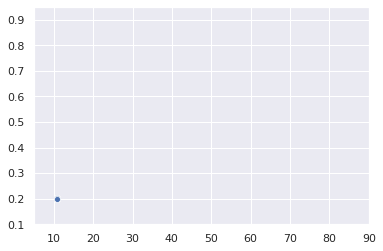

In [21]:
ax = sns.scatterplot(reconstruction_errors, disentanglement_metrics)
ax.set_xlim((5, 90))
ax.set_ylim((0.1, 0.95))
plt.savefig('chyvae_replication_metric_graph.pdf')

In [22]:
torch.save(model, 'dsprites_validation.pt')